## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему. 

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv` 

In [2]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

import gdown
# train
url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

output = 'train.csv'
gdown.download(url, output, quiet=True)

# test
url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

output = 'test.csv'
gdown.download(url, output, quiet=True)

# user features
url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
output = 'users.csv'
gdown.download(url, output, quiet=True, fuzzy=True)

# item features
url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
output = 'items.csv'
gdown.download(url, output, quiet=True)

'items.csv'

In [60]:
import pandas as pd
pd.read_csv('users.csv')

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0


In [61]:
df_items = pd.read_csv('items.csv')
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


In [113]:
df_test = pd.read_csv('test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608467 entries, 0 to 608466
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        608467 non-null  int64  
 1   item_id        608467 non-null  int64  
 2   last_watch_dt  608467 non-null  object 
 3   total_dur      608467 non-null  int64  
 4   watched_pct    608467 non-null  float64
 5   target         608467 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 27.9+ MB


In [114]:
df_train = pd.read_csv('train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4866956 entries, 0 to 4866955
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
 5   target         int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 222.8+ MB


In [64]:
df_users = pd.read_csv('users.csv')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


In [65]:
df_train.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1
2,889459,11460,2021-03-13,60,0.0,0
3,854016,11237,2021-03-13,5381,98.0,1
4,307257,9132,2021-03-13,5814,100.0,1




### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно. 

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



In [66]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import scipy.sparse as sp
from more_itertools import pairwise
from itertools import islice, cycle
from implicit.nearest_neighbours import CosineRecommender
from implicit.cpu.bpr import BayesianPersonalizedRanking
from implicit.cpu.als import AlternatingLeastSquares
from implicit.cpu.lmf import LogisticMatrixFactorization

import os
import torch
import warnings
import threadpoolctl
import re
from pathlib import Path
from rectools.dataset import Dataset

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import (
    MAP,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
)
from rectools.models import SASRecModel
from rectools.visuals import MetricsApp


## Разбиваем данные

In [115]:
df_train["last_watch_dt"] = pd.to_datetime(df_train["last_watch_dt"])
df_test["last_watch_dt"] = pd.to_datetime(df_test["last_watch_dt"])

In [116]:
df_train = df_train.sort_values("last_watch_dt")
df_test = df_test.sort_values("last_watch_dt")

split_date = df_train["last_watch_dt"].quantile(0.8)
train_stage = df_train[df_train["last_watch_dt"] <= split_date].copy()
valid_stage = df_train[df_train["last_watch_dt"] > split_date].copy()

In [117]:
train_stage['last_watch_dt'].max()

Timestamp('2021-07-26 00:00:00')

In [118]:
valid_stage['last_watch_dt'].min()

Timestamp('2021-07-27 00:00:00')

In [119]:
valid_stage_cold = valid_stage[~valid_stage['user_id'].isin(train_stage['user_id'].unique())]
valid_stage_cold.drop_duplicates(subset=['user_id', 'item_id'], inplace=True)
valid_stage_cold.shape

(361432, 6)

In [120]:
valid_stage_hot = valid_stage[valid_stage['user_id'].isin(train_stage['user_id'].unique())]
valid_stage_hot.drop_duplicates(subset=['user_id', 'item_id'], inplace=True)
valid_stage_hot.shape

(565253, 6)

In [121]:
users_inv_mapping = dict(enumerate(df_train['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
len(users_mapping)

880421

In [122]:
items_inv_mapping = dict(enumerate(df_train['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
len(items_mapping)

15418

In [123]:
def get_coo_matrix(df, user_col='user_id', item_col='item_id', weight_col=None, users_mapping=users_mapping, items_mapping=items_mapping):
    weights = np.ones(len(df), dtype=np.float32)
    interaction_matrix = sp.coo_matrix((weights, (df[user_col].map(users_mapping.get), df[item_col].map(items_mapping.get))))
    return interaction_matrix

In [124]:
train_coo_mat = get_coo_matrix(train_stage)
train_coo_mat = train_coo_mat.tocsr()
train_coo_mat

<749415x15009 sparse matrix of type '<class 'numpy.float32'>'
	with 3940271 stored elements in Compressed Sparse Row format>

In [125]:
df_train["weight"] = 1
df_train["datetime"] = df_train["last_watch_dt"]
interactions = df_train[["user_id", "item_id", "datetime", "weight"]]

In [126]:
split_date = interactions["datetime"].quantile(0.8)
train_interactions = interactions[interactions["datetime"] <= split_date].copy()
valid_interactions = interactions[interactions["datetime"] > split_date].copy()

## Метрики

In [20]:
def get_recall(df_true, df_pred, top_N, rank_col='rank'):
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])
    test_recs['relevant_items_count'] = test_recs.groupby('user_id')['rank'].transform('size')
    users_count = test_recs.index.get_level_values('user_id').nunique()
    k = top_N
    hit_k = f'hit@{k}'
    test_recs[hit_k] = test_recs[rank_col] <= k
    recall = (test_recs.groupby('user_id')[hit_k].sum() / test_recs.groupby('user_id')['relevant_items_count'].first()).mean()
    return float(recall)

In [21]:
def get_diversity(df_pred, top_N=30, rank_col='rank'):
    top_recommendations = df_pred[df_pred[rank_col] <= top_N]
    item_counts = top_recommendations['item_id'].value_counts().values
    if len(item_counts) == 0:
        return 0.0
    recommended_counter = item_counts
    n_items = len(recommended_counter)
    recommended_counter_sorted = np.sort(recommended_counter) 
    index = np.arange(1, n_items+1) 
    gini_diversity = 2 * np.sum((n_items + 1 - index)/(n_items+1) * recommended_counter_sorted/np.sum(recommended_counter_sorted))    
    return float(gini_diversity)

In [22]:
def eval_metrics(hot, recs, N=10):
    recall_pop = get_recall(valid_stage_hot, recs, 10) 
    gini_diversity_pop = get_diversity(recs, top_N=10)
    print(f"Индекс Джини {recall_pop:0.2f} и Recall {gini_diversity_pop:0.2f}")

## Эврестическая модель

In [30]:
class HeuristicModel:
    def __init__(self, max_K=200, days=30, item_column='item_id', dt_column='date'):
        self.max_K = max_K
        self.days = days
        self.item_column = item_column
        self.dt_column = dt_column
        self.recommendations = []
        
    def fit(self, df, ):
        min_date = df[self.dt_column].max().normalize() - pd.DateOffset(days=self.days)
        self.recommendations = df.loc[df[self.dt_column] > min_date, self.item_column].value_counts().head(self.max_K).index.values
    
    def recommend(self, users=None, N=10):
        recs = self.recommendations[:N]
        if users is None:
            return recs
        else:
            return list(islice(cycle([recs]), len(users)))

In [31]:
pop_model = HeuristicModel(days=30, dt_column='last_watch_dt')
pop_model.fit(train_stage)

top10_recs = pop_model.recommend(N=10)
top10_recs

array([15297,  9728, 10440,  3734, 13865,  2657,  4151, 12192,  4495,
        4880])

In [33]:
recs_pop = pd.DataFrame({'user_id': train_stage['user_id'].unique()})
recs_pop['item_id'] = pop_model.recommend(recs_pop['user_id'], N=10)
recs_pop = recs_pop.explode('item_id')
recs_pop['rank'] = recs_pop.groupby('user_id').cumcount() + 1
recs_pop

,user_id,item_id,rank
0,310745,15297,1
0,310745,9728,2
0,310745,10440,3
0,310745,3734,4
0,310745,13865,5
...,...,...,...
749414,778309,2657,6
749414,778309,4151,7
749414,778309,12192,8
749414,778309,4495,9


In [51]:
eval_metrics(valid_stage_hot, recs_pop)

Индекс Джини 0.20 и Recall 1.00


## Матричная Факторизация

In [55]:
als_model = AlternatingLeastSquares()
als_model.fit(train_coo_mat)

  0%|          | 0/15 [00:00<?, ?it/s]

In [67]:
def generate_recs(model, train_matrix, user_mapping, item_inv_mapping, N=10):
    recommendations = {}
    for user in user_mapping.keys():
        user_id = user_mapping[user]
        try:
            ids, scores = model.recommend(
                user_id,
                train_matrix[user_id],
                N=N,
                filter_already_liked_items=True
            )
            recs = [(item_inv_mapping[item], score) for item, score in zip(ids, scores)]
            recommendations[user] = recs
        except Exception:
            print("Out of range")
    
    return recommendations

In [ ]:
mapper_als = generate_recs(als_model, train_coo_mat, users_mapping, items_inv_mapping)

In [69]:
recs_als = pd.DataFrame({'user_id': valid_stage_hot['user_id'].unique()})
recs_als['item_id'] = recs_als['user_id'].map(mapper_als)
recs_als = recs_als.explode('item_id')
recs_als['rank'] = recs_als.groupby('user_id').cumcount() + 1
recs_als

,user_id,item_id,rank
0,491856,"(7713, 0.018015875)",1
0,491856,"(10436, 0.01408476)",2
0,491856,"(12132, 0.013723382)",3
0,491856,"(6945, 0.012837407)",4
0,491856,"(6939, 0.01059416)",5
...,...,...,...
151387,509102,"(5693, 0.013842618)",6
151387,509102,"(1287, 0.012484793)",7
151387,509102,"(3402, 0.012346473)",8
151387,509102,"(16361, 0.01221867)",9


In [70]:
eval_metrics(valid_stage_hot, recs_als)

Индекс Джини 0.00 и Recall 0.93


## Нейросетевая модель

In [23]:
dataset = Dataset.construct(
    interactions_df=train_interactions,
)

In [24]:
warnings.simplefilter("ignore")
torch.use_deterministic_algorithms(True)

In [25]:
sasrec = SASRecModel(
    session_max_len=20,
    loss="softmax",
    n_factors=64,
    lr=0.001,
    batch_size=16,
    deterministic=True,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
%%time
sasrec.fit(dataset)

`Trainer.fit` stopped: `max_epochs=3` reached.


CPU times: user 29min 44s, sys: 4min 36s, total: 34min 20s
Wall time: 32min 8s


In [28]:
recs_sas = sasrec.recommend(
    users=valid_stage_hot['user_id'].unique(),  
    dataset=dataset,
    k=10,
    filter_viewed=True,
    on_unsupported_targets="warn"
)
recs_sas

,user_id,item_id,score,rank
0,686772,10440,2.684944,1
1,686772,9728,2.474058,2
2,686772,13865,2.451519,3
3,686772,15297,2.269182,4
4,686772,3734,1.638870,5
...,...,...,...,...
1513735,489707,2657,1.499656,6
1513736,489707,4880,1.373923,7
1513737,489707,12995,0.979484,8
1513738,489707,142,0.900250,9


In [29]:
eval_metrics(valid_stage_hot, recs_sas)

Индекс Джини 0.23 и Recall 0.14


Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

## Признаки пользователя

In [30]:
def make_user_features(users, train_users):
    age_watch = train_users.merge(users[['user_id', 'age']], on='user_id', how='left')
    users['avg_watched_by_age'] = users['age'].map(age_watch.groupby('age')['watched_pct'].mean())
    users['watch_count'] = users['user_id'].map(train_users.groupby('user_id').size())
    
    return users

In [33]:
df_users = make_user_features(df_users, train_stage)
df_users.head()

,user_id,age,income,sex,kids_flg,avg_watched_by_age,watch_count
0,973171,age_25_34,income_60_90,М,1,49.741843,5.0
1,962099,age_18_24,income_20_40,М,0,48.873798,13.0
2,1047345,age_45_54,income_40_60,Ж,0,48.352909,NaN
3,721985,age_45_54,income_20_40,Ж,0,48.352909,13.0
4,704055,age_35_44,income_60_90,Ж,0,50.437727,9.0


## Признаки айтем

In [43]:
def make_item_features(items, train_users):
    
    items['item_popularity'] = items['item_id'].map(
        train_users.groupby('item_id').size()
    )
    items['item_avg_pct'] = items['item_id'].map(
        train_users.groupby('item_id')['watched_pct'].mean()
    )
    
    return items

In [44]:
df_items = make_item_features(df_items, train_stage)

In [45]:
df_items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,item_popularity,item_avg_pct
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...",4.0,75.250000
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...",9.0,38.777778
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...",6.0,69.000000
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю...",2.0,98.000000
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж...",1.0,100.000000


## Признаки взаимодействия

In [89]:
def make_interaction_features(train_users, features):
    boost = train_users.copy()
    
    for cols, new_col in features:
        avg_col = (train_users.groupby(cols)['watched_pct']
                    .mean()
                    .reset_index()
                    .rename(columns={'watched_pct': new_col}))
        boost = boost.merge(avg_col, on=cols, how='left')


    return boost

In [101]:
features = [
    (['item_id', 'age'], 'avg_item_age'),
    (['item_id', 'income'], 'avg_item_income'),
    (['item_id', 'sex'], 'avg_item_sex'),
    (['user_id', 'kids_flg'], 'avg_user_kids'),
    (['user_id'], 'avg_watched'),
    (['item_id', 'user_id'], 'interations_count')
]

In [80]:
train_stage = train_stage.merge(df_users, on='user_id', how='left')
train_stage = train_stage.merge(df_items, on='item_id', how='left')

In [90]:
boost = make_interaction_features(train_stage, features)

In [91]:
boost.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,age,income,sex,kids_flg,...,age_rating,studios,directors,actors,description,keywords,avg_item_age,avg_item_income,avg_item_sex,interations_count
0,310745,13373,2021-03-13,4485,98.0,1,age_35_44,income_90_150,М,1.0,...,0.0,NaN,Дункан МакНили,"Брайан Адамс, Дональд Сазерленд, Хелен Хант, Т...",История приключений очаровательного и бесстраш...,"2011, соединенные штаты, джок",57.484848,54.857143,57.994624,98.0
1,841963,3095,2021-03-13,83,1.0,0,age_45_54,income_20_40,М,0.0,...,12.0,NaN,Алан Тейлор,"Крис Хемсворт, Натали Портман, Том Хиддлстон, ...",Могучему Тору предстоит вновь сразиться за вос...,"супергерой, основанный на комическом, скандина...",57.122271,57.241234,58.114607,1.0
2,914523,13936,2021-03-13,5503,92.0,1,NaN,NaN,NaN,NaN,...,12.0,NaN,Владимир Котт,"Марина Неелова, Алиса Фрейндлих, Евгений Мирон...",Пенсионерка Елена Михайловна (Марина Неёлова) ...,"2017, россия, карп, отмороженный",NaN,NaN,NaN,92.0
3,306374,3095,2021-03-13,2865,44.0,0,NaN,NaN,NaN,NaN,...,12.0,NaN,Алан Тейлор,"Крис Хемсворт, Натали Портман, Том Хиддлстон, ...",Могучему Тору предстоит вновь сразиться за вос...,"супергерой, основанный на комическом, скандина...",NaN,NaN,NaN,44.0
4,505923,3221,2021-03-13,12765,100.0,1,age_35_44,income_40_60,Ж,1.0,...,12.0,"Ленфильм, рентв",Александр Иванов,"Андрей Абрикосов, Владимир Волчик, Долорес Сто...","Трехсерийный советский фильм, снятый по одноим...","Поднятая, целина, 1959, СССР, борьба, системой...",83.500000,100.000000,50.000000,100.0


In [104]:
valid_stage = valid_stage.merge(df_users, on='user_id', how='left')
valid_stage = valid_stage.merge(df_items, on='item_id', how='left')

In [105]:
valid_stage.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,age,income,sex,kids_flg,...,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,686772,5693,2021-07-27,7078,100.0,1,NaN,NaN,NaN,NaN,...,2019.0,"боевики, фантастика, триллеры, приключения",США,NaN,16.0,NaN,Роберт Родригес,"Роза Салазар, Кристоф Вальц, Дженнифер Коннелл...",Действие фильма происходит через 300 лет после...,"боевые искусства, охотник за головами, экстрем..."
1,1090560,2720,2021-07-27,1778,1.0,0,age_55_64,income_20_40,Ж,0.0,...,2017.0,драмы,США,NaN,16.0,NaN,"Майк Листо, Стивен ДеПол, Дэвид Стрейтон","Фредди Хаймор, Антония Томас, Хилл Харпер, Рич...",История молодого талантливого врача с синдромо...,"медсестра, сан-франциско, калифорния, аутизм, ..."
2,600461,4740,2021-07-27,3890,54.0,1,age_35_44,income_60_90,М,1.0,...,2021.0,документальное,Россия,NaN,16.0,NaN,Иван Проскуряков,"Алексей Усольцев, Чулпан Хаматова, Агата Супер","Его имя носят проспект, университет и даже аст...","Сахаров, Сахарок, Сахар, Сахар сахаров, Сахаро..."
3,960175,14215,2021-07-27,5036,93.0,1,age_35_44,income_20_40,Ж,1.0,...,2001.0,"мультфильм, фэнтези, приключения, комедии",США,NaN,6.0,NaN,"Эндрю Адамсон, Вики Дженсон","Джон Литгоу, Венсан Кассель, Питер Деннис, Кла...",Жил да был в сказочном государстве большой зел...,"магия, освобождение, правитель, принц, замок, ..."
4,454186,16166,2021-07-27,5722,91.0,1,age_25_34,income_60_90,М,1.0,...,2016.0,"приключения, мультфильм, детективы, комедии",США,NaN,6.0,NaN,"Байрон Ховард, Рич Мур, Джаред Буш","Джиннифер Гудвин, Джейсон Бейтман, Идрис Эльба...",Добро пожаловать в Зверополис — современный го...,"аллегория, лев, бегемот, лиса, слон, овца, бел..."


In [106]:
valid_boost = make_interaction_features(valid_stage, features)


### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [107]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

features = [
    'total_dur', 'age', 
    'income', 'sex', 'kids_flg', 'avg_item_age', 
    'avg_item_income', 'avg_item_sex', 'interations_count'
]  

X_valid = boost[features]
y_valid = boost['target']


X_valid = pd.get_dummies(X_valid)

In [97]:
dtrain = xgb.DMatrix(data=X_valid, label=y_valid)

params = {
    'objective': 'binary:logistic', 
    'max_depth': 6,
    'eta': 0.1,
    'eval_metric': 'logloss'
}

bst = xgb.train(params, dtrain, num_boost_round=100)

In [109]:
X_test = valid_boost[features]
X_test = pd.get_dummies(X_test)

X_test = X_test.reindex(columns=X_valid.columns, fill_value=0)

dtest = xgb.DMatrix(data=X_test)
predictions = bst.predict(dtest)

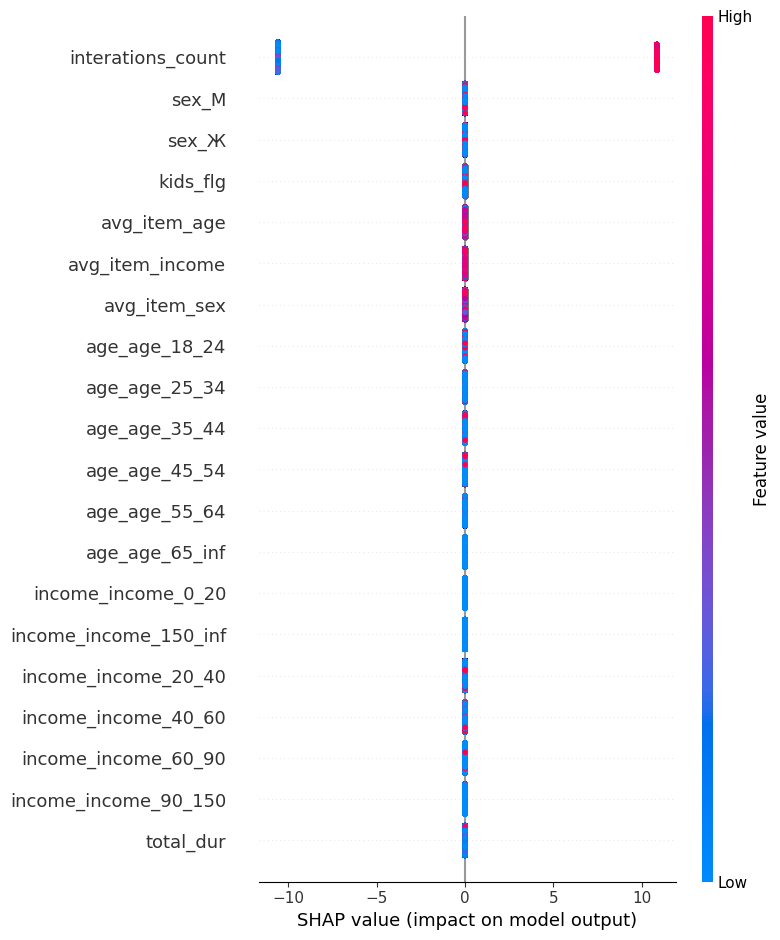

In [112]:
import shap

explainer = shap.Explainer(bst)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [127]:
df_test["weight"] = 1
df_test["datetime"] = df_test["last_watch_dt"]
interactions_test = df_test[["user_id", "item_id", "datetime", "weight"]]

In [128]:
big_interactions = pd.concat([interactions, interactions_test])

In [129]:
big_dataset = Dataset.construct(
    interactions_df=big_interactions,
)

In [ ]:
%%time
sasrec.fit(big_dataset)

In [ ]:
recs_sas = sasrec.recommend(
    users=valid_stage_hot['user_id'].unique(),  
    dataset=big_dataset,
    k=10,
    filter_viewed=True,
    on_unsupported_targets="warn"
)
recs_sas

In [ ]:
eval_metrics(valid_stage_hot, recs_sas)